In [21]:
from core.gradient_descent import wolfe_conditions_search, point_number_terminate_condition
%load_ext autoreload
%autoreload 2

from core.high_order_optimization import *
from core.optimizer_evaluator import *
from core.utils import *
from core.visualizer import *
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
f1 = lambda x: np.exp(x[0])
f2 = lambda x: np.sin(x[0])
f3 = lambda x: np.exp(-(x[0] + 1))
fs = [f1, f2, f3]

df1 = lambda x: np.array([np.exp(x[0])])
df2 = lambda x: np.array([np.cos(x[0])])
df3 = lambda x: np.array([-np.exp(-(x[0] + 1))])
dfs = [df1, df2, df3]

x0 = np.array([10])

termination = lambda f, points: len(points) > 20

p1 = gauss_newton(fs, dfs, x0, termination)
p2 = gauss_newton_with_approx_grad(fs, x0, termination)

print(f"symbolic grad argmin = {p1[-1]}, approx grad argmin = {p2[-1]}")

symbolic grad argmin = [-0.30823297], approx grad argmin = [-0.3083785]


# Вычисление гессианы: Аналитически, численно

In [23]:
q = QuadraticForm(np.array([
    [10, 2],
    [2, 2]
                  ]))

In [24]:
x = np.array([3, 4])
q.gradient_function()(x)

array([76, 28])

In [25]:
symmetric_gradient_computer(q)(x)

array([76., 28.])

In [26]:
q.hessian_function()(x)

array([[20,  4],
       [ 4,  4]])

In [27]:
symmetric_hessian_computer(q)(x)

array([[20.00000165,  3.99985822],
       [ 3.99985822,  3.99992928]])

# Метод Ньютона

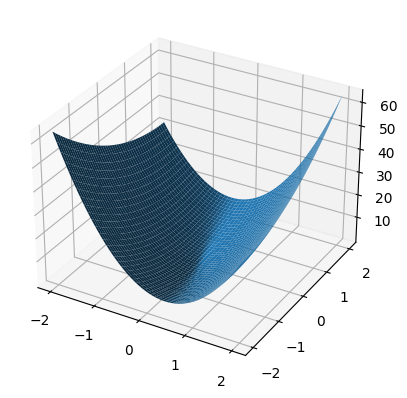

In [28]:
roi = SearchRegion2d((-2, 2), (-2, 2))
visualize_function_3d(q, roi)

Best value found: x* = [-1.30923418e-09  8.72822784e-10] with f(x*) = 1.4093662827614176e-17


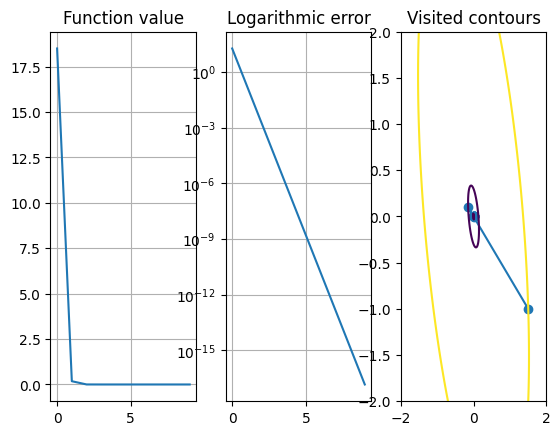

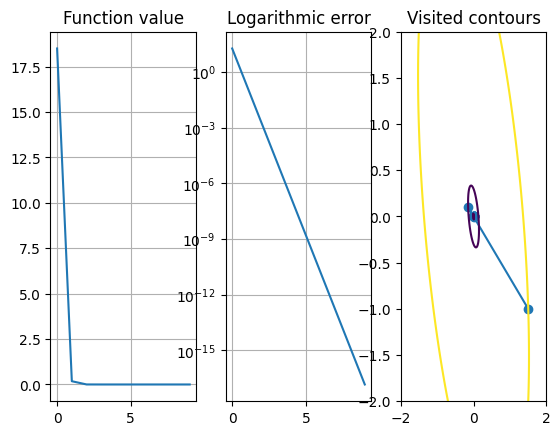

In [29]:
visualize_optimizing_process(q, roi, np.array(newton_optimize(
    q, q.gradient_function(), GivenInverseHessianController(lambda x: np.linalg.inv(q.hessian_function()(x))), np.array([1.5, -1.]), wolfe_conditions_search(0.1, 0.9), point_number_terminate_condition(10)
)), 0)

Достаточно ≈11 итераций для матрицы со сколь угодно большим числом обусловленности

In [75]:
form = generate_positive_definite_quadratic_form(100, 100, random_orthonormal_basis)

In [50]:
points = newton_optimize(form, form.gradient_function(), GivenInverseHessianController(lambda x: np.linalg.inv(form.hessian_function()(x))), random_normalized_vector(form.n), wolfe_conditions_search(0.1, 0.9),
                         precision_termination_condition)

In [51]:
len(points)

11

In [52]:
[form(p) for p in points]

[25.26571077541266,
 0.24513424237074938,
 0.0023783537030416164,
 2.3075382215335653e-05,
 2.2388312709874224e-07,
 2.172170069893777e-09,
 2.1074937060627048e-11,
 2.0447430809647016e-13,
 1.9838608557290054e-15,
 1.92479139874969e-17,
 1.867480734851935e-19]

# BFGS

Best value found: x* = [-9.53545419e-09  8.52754320e-08] with f(x*) = 1.220048757809216e-14


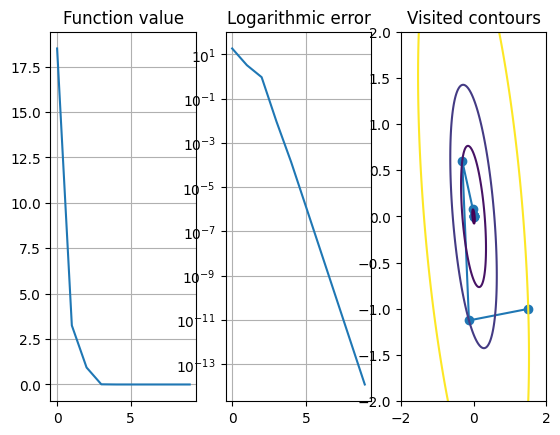

In [58]:
visualize_optimizing_process(q, roi, np.array(newton_optimize(
    q, q.gradient_function(), BFGSInverseHessianController(),
    np.array([1.5, -1.]), wolfe_conditions_search(0.1, 0.9), point_number_terminate_condition(10)
)), 0);

In [76]:
bfgs_points = newton_optimize(form, form.gradient_function(), BFGSInverseHessianController(), random_normalized_vector(form.n), wolfe_conditions_search(0.1, 0.9),
                precision_termination_condition)

[newton_optimize] Computed initial approximation
1.0555966381712919e-06
1.868363832294241e-10
4.4240398671114965e-14
1.1505000210213883e-16
9.569182331327498e-17
9.878712500127401e-17
9.655189277696822e-17
1.2004548780673872e-16
1.2875390104507833e-16


In [72]:
[form(p) for p in bfgs_points]

[22.812793509825166,
 0.22132922204136118,
 0.0021473914445337434,
 2.0834528642727593e-05,
 2.021418055239059e-07,
 1.9612303326443213e-09,
 1.9028346994898606e-11,
 1.846177796312562e-13,
 1.791207852427367e-15,
 1.7378746386213564e-17,
 1.6861294212564313e-19]

In [73]:
len(bfgs_points)

11